In [ ]:
# Copyright (c) ContextualFairness contributors.
# Licensed under the MIT License.

# Binary classification

This notebook matches the experiments for Binary classification in the paper ... (Section 4.1)

In [1]:
# Make sure
import sys

sys.path.append("../")

In [18]:
from folktables import ACSDataSource, ACSIncome

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from fairlearn.preprocessing import CorrelationRemover

from contextualfairness import (
    contextual_fairness_score,
    BinaryClassificationEqualityNorm,
    RankNorm,
)

from helper import group_plot

In [3]:
# load data
data_source = ACSDataSource(
    survey_year="2016", horizon="1-Year", survey="person", root_dir="data/raw"
)
acs_data_ca = data_source.get_data(states=["CA"], download="True")

In [4]:
# Prepare data
X, y, _ = ACSIncome.df_to_pandas(acs_data_ca)
y = y["PINCP"]
sensitive_attribute = X["SEX"].copy()

# divide into training and test set
X_train, X_test, y_train, y_test, sens_train, sens_test = train_test_split(
    X, y, sensitive_attribute, test_size=0.2, random_state=0
)

In [5]:
# Train model
clf = LogisticRegression(max_iter=10_000, penalty="l2", random_state=42)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [6]:
# predictions
y_pred = clf.predict(X_test)
y_pred_probas = clf.predict_proba(X_test)[:, 1]

### Equalized odds

TODO: explain equalized odds (show equations that should hold) -> copy from paper

In [7]:
# calculate probabilities for each combination of sex (Male/Female) and y_true (True/False)
male_true = len(X_test[(sens_test == 1.0) & y_test & y_pred]) / len(
    X_test[(sens_test == 1.0) & y_test]
)
male_false = len(X_test[(sens_test == 1.0) & ~y_test & y_pred]) / len(
    X_test[(sens_test == 1.0) & ~y_test]
)

female_true = len(X_test[(sens_test == 2.0) & y_test & y_pred]) / len(
    X_test[(sens_test == 2.0) & y_test]
)

female_false = len(X_test[(sens_test == 2.0) & ~y_test & y_pred]) / len(
    X_test[(sens_test == 2.0) & ~y_test]
)

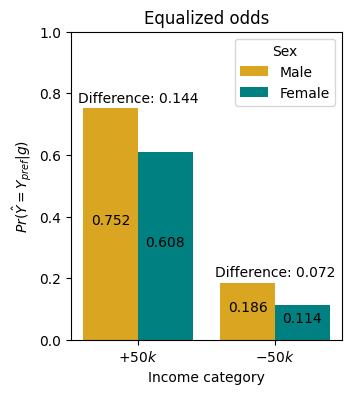

In [8]:
# plot results
groups = [
    [male_true, male_false],  # male
    [female_true, female_false],  # female
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="$Pr(\hat{Y}=Y_{pref}|g)$",
    title="Equalized odds",
)

### Contextual fairness with equality norm

In [9]:
norms = [BinaryClassificationEqualityNorm(positive_class_value=True)]

X_test_copy = X_test.copy()
# Add y_true to X_test, so we can calculate scores for the same groups as for equalized odds.
X_test_copy["y_true"] = y_test

result = contextual_fairness_score(norms, X_test_copy, y_pred, y_pred_probas)

total_score = result.total_score()

scaled_group_scores = result.group_scores(["SEX", "y_true"], scaled=True)
unscaled_group_scores = result.group_scores(["SEX", "y_true"])

/Users/pimk/Developer/contextual-fairness/examples/../contextualfairness/scorer.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.62895e-05 2.62895e-05 2.62895e-05 ... 2.62895e-05 2.62895e-05
 2.62895e-05]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[:, norm.name] = (


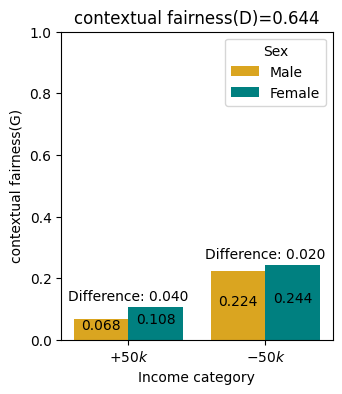

In [10]:
groups = [
    [
        scaled_group_scores["SEX=1.0;y_true=True"]["score"],
        scaled_group_scores["SEX=1.0;y_true=False"]["score"],
    ],
    [
        scaled_group_scores["SEX=2.0;y_true=True"]["score"],
        scaled_group_scores["SEX=2.0;y_true=False"]["score"],
    ],
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="contextual fairness(G)",
    title=f"contextual fairness(D)={total_score:.3f}",
)

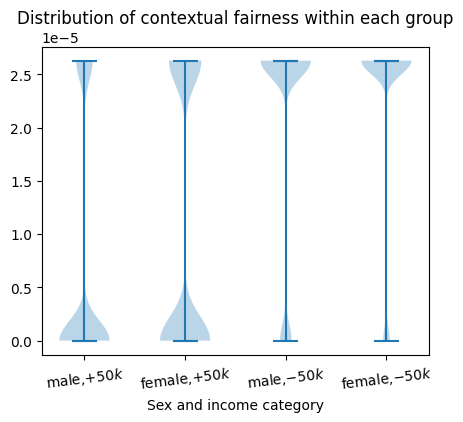

In [11]:
# Plot IN-GROUP scores
violin_data = [
    unscaled_group_scores["SEX=1.0;y_true=True"]["data"],
    unscaled_group_scores["SEX=2.0;y_true=True"]["data"],
    unscaled_group_scores["SEX=1.0;y_true=False"]["data"],
    unscaled_group_scores["SEX=2.0;y_true=False"]["data"],
]
fig, ax = plt.subplots(figsize=(5, 4))
ax.violinplot(violin_data, showmeans=False, showmedians=True)
ax.tick_params(axis="x", labelrotation=7)
ax.set_xticks(
    [y + 1 for y in range(len(violin_data))],
    labels=["male,$+50k$", "female,$+50k$", "male,$-50k$", "female,$-50k$"],
)
ax.set_xlabel("Sex and income category")
ax.set_title("Distribution of contextual fairness within each group")

plt.show()

### Contextual fairness with multiple norms

TODO: describe example

In [13]:
def work_more_hours(x):
    return x["WKHP"]


def lower_education(x):
    return -x["SCHL"]


norms = [
    BinaryClassificationEqualityNorm(positive_class_value=True),
    RankNorm(norm_function=work_more_hours),
    RankNorm(norm_function=lower_education),
]

X_test_copy = X_test.copy()
# Add y_true to X_test, so we can calculate scores for the same groups as for equalized odds.
X_test_copy["y_true"] = y_test

result = contextual_fairness_score(norms, X_test_copy, y_pred, y_pred_probas)

total_score = result.total_score()

scaled_group_scores = result.group_scores(["SEX", "y_true"], scaled=True)
unscaled_group_scores = result.group_scores(["SEX", "y_true"])

/Users/pimk/Developer/contextual-fairness/examples/../contextualfairness/scorer.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8.67553499e-06 8.67553499e-06 8.67553499e-06 ... 8.67553499e-06
 8.67553499e-06 8.67553499e-06]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[:, norm.name] = (
/Users/pimk/Developer/contextual-fairness/examples/../contextualfairness/scorer.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4.10297835e-07 3.26640316e-06 2.43217789e-06 ... 1.94762226e-06
 2.81521653e-07 2.09989774e-06]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[:, norm.name] = (
/Users/pimk/Developer/contextual-fairness/examples/../contextualfairness/scorer.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated a

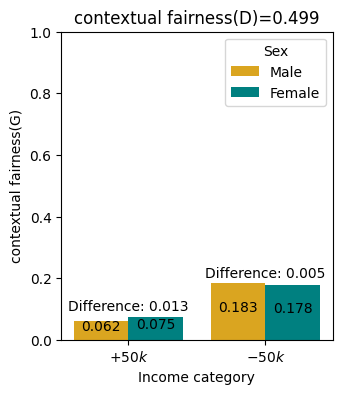

In [14]:
groups = [
    [
        scaled_group_scores["SEX=1.0;y_true=True"]["score"],
        scaled_group_scores["SEX=1.0;y_true=False"]["score"],
    ],
    [
        scaled_group_scores["SEX=2.0;y_true=True"]["score"],
        scaled_group_scores["SEX=2.0;y_true=False"]["score"],
    ],
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="contextual fairness(G)",
    title=f"contextual fairness(D)={total_score:.3f}",
)

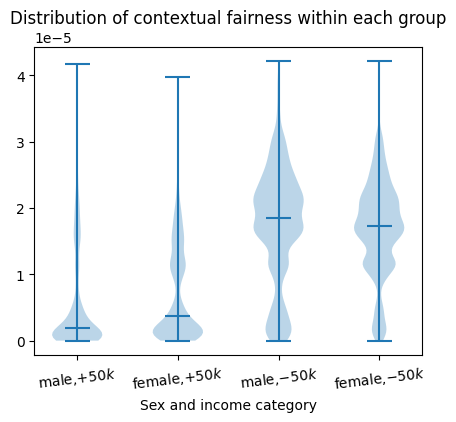

In [15]:
# Plot IN-GROUP scores
violin_data = [
    unscaled_group_scores["SEX=1.0;y_true=True"]["data"],
    unscaled_group_scores["SEX=2.0;y_true=True"]["data"],
    unscaled_group_scores["SEX=1.0;y_true=False"]["data"],
    unscaled_group_scores["SEX=2.0;y_true=False"]["data"],
]
fig, ax = plt.subplots(figsize=(5, 4))
ax.violinplot(violin_data, showmeans=False, showmedians=True)
ax.tick_params(axis="x", labelrotation=7)
ax.set_xticks(
    [y + 1 for y in range(len(violin_data))],
    labels=["male,$+50k$", "female,$+50k$", "male,$-50k$", "female,$-50k$"],
)
ax.set_xlabel("Sex and income category")
ax.set_title("Distribution of contextual fairness within each group")

plt.show()

## Mitigate model

Describe how we mitigate model

In [19]:
remover = CorrelationRemover(sensitive_feature_ids=["SEX"])
X_train = remover.fit_transform(X_train)
# X_test = remover.transform(X_test)

clf = LogisticRegression(max_iter=10_000, penalty="l2")
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [20]:
X_test_corr_removed = remover.transform(X_test)

y_pred = clf.predict(X_test_corr_removed)
y_pred_probas = clf.predict_proba(X_test_corr_removed)[:, 1]

### Equalized odds

In [21]:
male_true = len(X_test[(sens_test == 1.0) & y_test & y_pred]) / len(
    X_test[(sens_test == 1.0) & y_test]
)
male_false = len(X_test[(sens_test == 1.0) & ~y_test & y_pred]) / len(
    X_test[(sens_test == 1.0) & ~y_test]
)

female_true = len(X_test[(sens_test == 2.0) & y_test & y_pred]) / len(
    X_test[(sens_test == 2.0) & y_test]
)

female_false = len(X_test[(sens_test == 2.0) & ~y_test & y_pred]) / len(
    X_test[(sens_test == 2.0) & ~y_test]
)

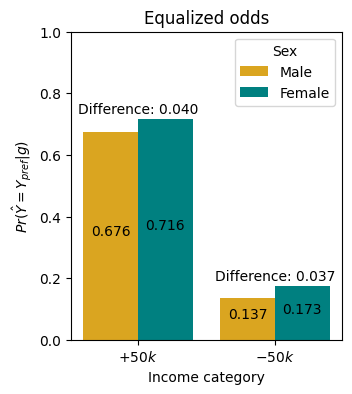

In [22]:
# plot results
groups = [
    [male_true, male_false],  # male
    [female_true, female_false],  # female
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="$Pr(\hat{Y}=Y_{pref}|g)$",
    title="Equalized odds",
)

### Contextual fairness

In [23]:
def work_more_hours(x):
    return x["WKHP"]


def lower_education(x):
    return -x["SCHL"]


norms = [
    BinaryClassificationEqualityNorm(positive_class_value=True),
    RankNorm(norm_function=work_more_hours),
    RankNorm(norm_function=lower_education),
]

X_test_copy = X_test.copy()
# Add y_true to X_test, so we can calculate scores for the same groups as for equalized odds.
X_test_copy["y_true"] = y_test

result = contextual_fairness_score(norms, X_test_copy, y_pred, y_pred_probas)

total_score = result.total_score()

scaled_group_scores = result.group_scores(["SEX", "y_true"], scaled=True)
unscaled_group_scores = result.group_scores(["SEX", "y_true"])

/Users/pimk/Developer/contextual-fairness/examples/../contextualfairness/scorer.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8.67553499e-06 8.67553499e-06 8.67553499e-06 ... 8.67553499e-06
 8.67553499e-06 8.67553499e-06]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[:, norm.name] = (
/Users/pimk/Developer/contextual-fairness/examples/../contextualfairness/scorer.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3.63769215e-07 2.94023283e-06 2.95762231e-06 ... 1.70980931e-06
 2.45332726e-07 2.29212204e-06]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[:, norm.name] = (
/Users/pimk/Developer/contextual-fairness/examples/../contextualfairness/scorer.py:103: FutureWarning: Setting an item of incompatible dtype is deprecated a

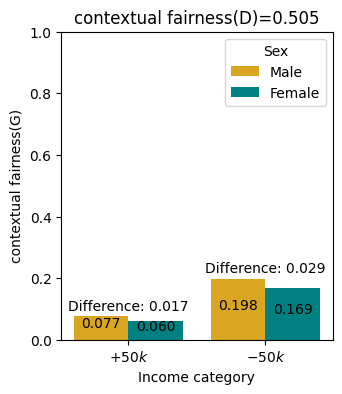

In [24]:
groups = [
    [
        scaled_group_scores["SEX=1.0;y_true=True"]["score"],
        scaled_group_scores["SEX=1.0;y_true=False"]["score"],
    ],
    [
        scaled_group_scores["SEX=2.0;y_true=True"]["score"],
        scaled_group_scores["SEX=2.0;y_true=False"]["score"],
    ],
]

group_plot(
    groups,
    legend=["Male", "Female"],
    legend_title="Sex",
    xticks=["$+50k$", "$-50k$"],
    xlabel="Income category",
    ylabel="contextual fairness(G)",
    title=f"contextual fairness(D)={total_score:.3f}",
)

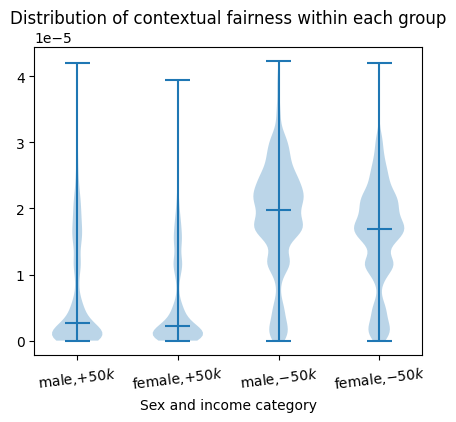

In [25]:
# Plot IN-GROUP scores
violin_data = [
    unscaled_group_scores["SEX=1.0;y_true=True"]["data"],
    unscaled_group_scores["SEX=2.0;y_true=True"]["data"],
    unscaled_group_scores["SEX=1.0;y_true=False"]["data"],
    unscaled_group_scores["SEX=2.0;y_true=False"]["data"],
]
fig, ax = plt.subplots(figsize=(5, 4))
ax.violinplot(violin_data, showmeans=False, showmedians=True)
ax.tick_params(axis="x", labelrotation=7)
ax.set_xticks(
    [y + 1 for y in range(len(violin_data))],
    labels=["male,$+50k$", "female,$+50k$", "male,$-50k$", "female,$-50k$"],
)
ax.set_xlabel("Sex and income category")
ax.set_title("Distribution of contextual fairness within each group")

plt.show()